In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torchvision.models as models

from pathlib import Path
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader
from torchvision.models import EfficientNet
from utils.loss_functions import tkd_kdloss

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters / Inputs
teacher_learning_rate = 0.0005 # 0.096779
student_learning_rate = teacher_learning_rate
teacher_epochs = 200
student_epochs = teacher_epochs
teacher_patience = 3
student_patience = 6
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 64
num_workers = 4
epsilon = 0.05
margin = 0.01
num_classes = 16
base_save_dir = "Test_Dir4"

# list of lambda values to loop through for grid search
teacher_lambda_factor_list = [0]
student_lambda_factor_list = [150,0,50,100,150,200]

In [3]:
# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
class_names_new = [f"Class {label}" for label in range(num_classes)]


In [4]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [6]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water_Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [7]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [8]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [9]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [10]:
# train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=num_workers, collate_fn=custom_collate)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)


Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [11]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)

    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [12]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)  # Outputting a single value for bias

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
        

In [13]:
def train_teacher(teacher, teacher_optimizer, teacher_loss_fn, patience=teacher_patience, 
                  epochs=teacher_epochs, device=device, base_save_dir=base_save_dir):
    
    train_accuracies = []
    train_disparities = []
    train_mean_non_zero_abs_disparities = []
    train_losses = []
    train_main_losses = []
    val_accuracies = []
    val_disparities = []
    val_mean_non_zero_abs_disparities = []
    val_losses = []
    val_main_losses = []
    
    patience_counter = 0 
    best_val_accuracy = 0
    best_val_loss = float('inf')
    best_val_mean_abs_disparity = 0
    teacher_best_model_state = None

    # Create a subdirectory for the current lambda_factor
    lambda_dir = os.path.join(base_save_dir, f'TEACHER_lambda_{lambda_factor}')
    os.makedirs(lambda_dir, exist_ok=True)

    print(f'Training Teacher with Lambda Value of {lambda_factor}')
    
    # Training and Validation Loop
    for epoch in range(epochs):
        # Initialize metrics for each epoch
        epoch_train_disparities = []
        epoch_train_losses = []
        epoch_train_accuracies = []
        epoch_val_disparities = []
        epoch_val_losses = []
        epoch_val_accuracies = []
    
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        
        # Training
        for batch_data in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}, Training'):
            # Load data to device
            teacher.train()
            teacher.to(device)
            images = batch_data["img"].to(device)
            labels = batch_data["label"].to(device)
            gender_scores = batch_data["target"].to(device)
    
            teacher_optimizer.zero_grad()            
            # Forward pass through actor
            teacher_output = teacher(images)
    
            main_loss = teacher_loss_fn(teacher_output, labels)
            class_predictions = torch.argmax(teacher_output, dim=1)

            main_loss.backward()
            teacher_optimizer.step()
    
            # Calculate and accumulate metrics
            accuracy = (class_predictions == labels).float().mean().item()
            epoch_train_accuracies.append(accuracy)
    
            total_samples += labels.size(0)
            total_correct += (class_predictions == labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]
            bias = np.mean(recall_diff[0])
            epoch_train_disparities.append(bias)        
            # Record the losses
            epoch_train_losses.append(main_loss.item())
    
        confusion_male /= num_batches
        confusion_female /= num_batches
    
        # Calculate training metrics for the epoch
        train_epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        train_non_zero_abs_values = np.abs(train_epoch_disparity[train_epoch_disparity != 0])
        
        # Store average training metrics for the epoch
        train_accuracy = np.mean(epoch_train_accuracies)
        train_disparity = np.mean(epoch_train_disparities)
        train_mean_non_zero_abs_disparity = np.mean(train_non_zero_abs_values)
        train_main_loss = np.mean([x for x in epoch_train_losses])
        train_accuracies.append(train_accuracy)
        train_disparities.append(train_disparity)
        train_mean_non_zero_abs_disparities.append(train_mean_non_zero_abs_disparity)
        train_main_losses.append(train_main_loss)

        # Validation Phase
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        total_correct = 0
        total_samples = 0
        num_batches = 0
        
        teacher.eval()
        with torch.no_grad():
            for batch_data in tqdm(testloader, desc=f'Epoch {epoch+1}/{epochs}, Validation'):
                # Load data to device
                images = batch_data["img"].to(device)
                labels = batch_data["label"].to(device)
                gender_scores = batch_data["target"].to(device)
        
                # Forward pass
                teacher_output = teacher(images)
                class_predictions = torch.argmax(teacher_output, dim=1)
        
                # Calculate and accumulate validation metrics
                accuracy = (class_predictions == labels).float().mean().item()
    
                # Compute bias
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
                
                # Calculate validation losses (similar to training losses)
                batch_bias = np.mean(recall_diff[0])
                val_main_loss = teacher_loss_fn(teacher_output, labels)
            
                epoch_val_accuracies.append(accuracy)
                epoch_val_losses.append(val_main_loss.item())
                
            confusion_male /= num_batches
            confusion_female /= num_batches
    
            val_epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_non_zero_abs_values = np.abs(val_epoch_disparity[val_epoch_disparity != 0])
    
            # Store average training metrics for the epoch
            val_accuracy = np.mean(epoch_val_accuracies)
            val_disparity = np.mean(epoch_val_disparities)
            val_mean_non_zero_abs_disparity = np.mean(val_non_zero_abs_values)
            val_main_loss = np.mean([x for x in epoch_val_losses])

        
            val_accuracies.append(val_accuracy)
            val_disparities.append(val_disparity)
            val_mean_non_zero_abs_disparities.append(val_mean_non_zero_abs_disparity)
            val_main_losses.append(val_main_loss)


            # Check if current validation combined loss is lower than the best combined loss
        if val_main_loss < best_val_loss:
            best_val_loss = val_main_loss
            best_val_accuracy = val_accuracy
            best_val_mean_non_zero_abs_disparity = val_mean_non_zero_abs_disparity
        
            # Create a mapping of class recall disparities
            class_recall_mapping = {class_name: val_epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
        
            teacher_best_model_state = {
                'epoch': epoch,
                'teacher_state_dict': teacher.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_accuracy': best_val_accuracy,
                'best_val_mean_abs_disparity': best_val_mean_non_zero_abs_disparity,
                'class_recall_mapping': class_recall_mapping
            }
            save_path = os.path.join(lambda_dir, f'TEACHER_best_model_lambda_{lambda_factor}.pth')
            torch.save(teacher_best_model_state, save_path)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        print("\n" + "="*50)
        print(f"TEACHER - Lambda {lambda_factor} - Epoch {epoch + 1} Metrics:")
        print("-"*50)
        print(f"TRAINING Accuracy: {train_accuracy:.6f}, VALIDATION Accuracy: {val_accuracy:.4f}")
        print(f"TRAINING Disparity: {train_mean_non_zero_abs_disparity:.6f}, VALIDATION Disparity: {val_mean_non_zero_abs_disparity:.4f}")
        print(f"TRAINING Main Loss: {train_main_loss:.6f}, VALIDATION Main Loss: {val_main_loss:.4f}")
        print("-"*50 + "\n")
        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Val Disparity = {recall_diff}")
        print("="*50 + "\n")
      
        # Plotting
        plt.figure(figsize=(15, 10))
        
        # Plot Training and Validation Accuracy
        plt.subplot(2, 2, 1)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title('Teacher Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Plot Training and Validation Disparity
        plt.subplot(2, 2, 2)
        plt.plot(train_mean_non_zero_abs_disparities, label='Training Mean Absolute Disparity')
        plt.plot(val_mean_non_zero_abs_disparities, label='Validation Mean Absolute Disparity')
        plt.title('Teacher Training and Validation Mean Absolute Disparity')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Absolute Disparity')
        plt.legend()
        
        # Plot Training Loss Components, Including Combined Loss
        plt.subplot(2, 2, 3)
        plt.plot(train_main_losses, label='Training Main Loss')
        plt.title('Teacher Training Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    
        # Plot Validation Loss Components, Including Combined Loss
        plt.subplot(2, 2, 4)
        plt.plot(val_main_losses, label='Validation Main Loss')
        plt.title('Teacher Validation Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
            
        plt.tight_layout()
        plt.show()

    best_epoch = teacher_best_model_state['epoch'] + 1 if teacher_best_model_state else epochs
    print(f"Finished Training TEACHER with lambda value of {lambda_factor}. Best epoch number: {best_epoch}")

    return teacher_best_model_state

In [14]:
def train_student(student, teacher, student_optimizer, student_loss_fn, critic, critic_optimizer, critic_loss_fn,
                  lambda_factor, temperature, alpha, epsilon=epsilon, margin=margin, patience=student_patience, 
                  epochs=student_epochs, device=device, base_save_dir=base_save_dir):
    
    train_accuracies = []
    train_disparities = []
    train_mean_non_zero_abs_disparities = []
    train_losses = []
    train_main_losses = []
    train_critic_losses = []
    train_kd_losses = []
    val_accuracies = []
    val_disparities = []
    val_mean_non_zero_abs_disparities = []
    val_losses = []
    val_main_losses = []
    val_critic_losses = []
    val_kd_losses = []
    
    patience_counter = 0 
    best_val_accuracy = 0
    best_val_loss = float('inf')
    best_val_mean_abs_disparity = 0
    student_best_model_state = None

    teacher.eval()
    teacher.to(device)

    student.to(device)
    critic.to(device)
    
    # Create a subdirectory for the current lambda_factor
    lambda_dir = os.path.join(base_save_dir, f'STUDENT_lambda_{lambda_factor}')
    os.makedirs(lambda_dir, exist_ok=True)

    print(f'Training Student with Lambda Value of {lambda_factor}')
    
    # Training and Validation Loop
    for epoch in range(epochs):
        # Initialize metrics for each epoch
        epoch_train_disparities = []
        epoch_train_losses = []
        epoch_train_accuracies = []
        epoch_val_disparities = []
        epoch_val_losses = []
        epoch_val_accuracies = []
    
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0

            # student.eval()
            # student.to(device)
            # critic.train()
            # critic.to(device)

        # Training
        student.train()
        for batch_data in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}, Training'):
            # Load data to device
            images = batch_data["img"].to(device)
            labels = batch_data["label"].to(device)
            gender_scores = batch_data["target"].to(device)
            
            # Forward pass through student
            student_output = student(images)
            class_predictions = torch.argmax(student_output, dim=1)
            
            # Compute bias
            total_samples += labels.size(0)
            total_correct += (class_predictions == labels).sum().item()
            num_batches += 1
            recall_diff = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes=num_classes)
            confusion_male += recall_diff[1]
            confusion_female += recall_diff[2]
            bias = np.mean(recall_diff[0])
            bias_mean = torch.tensor([bias], device=device, dtype=torch.float32)

            critic_optimizer.zero_grad()
            
            for param in critic.parameters():
                param.requires_grad = True
            for param in student.parameters():
                param.requires_grad = False
                
            critic.train()
            student.eval()
            
            critic_output = critic(student_output)
            critic_loss = critic_loss_fn(critic_output, bias_mean)
            critic_loss.backward(retain_graph=True)
    
            critic_optimizer.step()
    
            for param in critic.parameters():
                param.requires_grad = False
            for param in student.parameters():
                param.requires_grad = True
                
            student.train()
            critic.eval()
    
            student_optimizer.zero_grad()
    
            critic_output = critic(student_output)
            main_loss = student_loss_fn(student_output, labels)

            with torch.no_grad():
                teacher_output = teacher(images)
            
            kd_loss = tkd_kdloss(student_output, teacher_output, temperature=temperature)
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
            else:
                kd_loss = 0 
            
            # combined_loss = (alpha * kd_loss + (1 - alpha) * main_loss) * max(1, lambda_factor * (abs(critic_output[0][0]) - epsilon + margin) + 1)
            combined_loss = alpha * kd_loss + (1 - alpha) * max(1, lambda_factor * (abs(critic_output[0][0]) - epsilon + margin) + 1) * main_loss
            # combined_loss = max(1, lambda_factor * (abs(critic_output[0][0]) - epsilon + margin) + 1) * main_loss

            combined_loss.backward(retain_graph=True)
            student_optimizer.step()
    
            # Calculate and accumulate metrics
            accuracy = (class_predictions == labels).float().mean().item()
            epoch_train_accuracies.append(accuracy)
            epoch_train_disparities.append(bias)
        
            # Record the losses
            epoch_train_losses.append((combined_loss.item(), main_loss.item(), critic_loss.item(), kd_loss))
    
        confusion_male /= num_batches
        confusion_female /= num_batches
    
        # Calculate training metrics for the epoch
        train_epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
        train_non_zero_abs_values = np.abs(train_epoch_disparity[train_epoch_disparity != 0])
        
        # Store average training metrics for the epoch
        train_accuracy = np.mean(epoch_train_accuracies)
        train_disparity = np.mean(epoch_train_disparities)
        train_mean_non_zero_abs_disparity = np.mean(train_non_zero_abs_values)
        train_combined_loss = np.mean([x[0] for x in epoch_train_losses])
        train_main_loss = np.mean([x[1] for x in epoch_train_losses])
        train_critic_loss = np.mean([x[2] for x in epoch_train_losses])
        train_kd_loss = np.mean([x[3] for x in epoch_train_losses])

        train_accuracies.append(train_accuracy)
        train_disparities.append(train_disparity)
        train_mean_non_zero_abs_disparities.append(train_mean_non_zero_abs_disparity)
        train_losses.append(train_combined_loss)
        train_main_losses.append(train_main_loss)
        train_critic_losses.append(train_critic_loss)
        train_kd_losses.append(train_kd_loss)

        # Validation Phase
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        total_correct = 0
        total_samples = 0
        num_batches = 0
        
        student.eval()
        with torch.no_grad():
            for batch_data in tqdm(testloader, desc=f'Epoch {epoch+1}/{epochs}, Validation'):
                # Load data to device
                images = batch_data["img"].to(device)
                labels = batch_data["label"].to(device)
                gender_scores = batch_data["target"].to(device)
        
                # Forward pass
                student_output = student(images)
                val_critic_output = critic(student_output)
                class_predictions = torch.argmax(student_output, dim=1)
                teacher_output = teacher(images)
                
                # Calculate and accumulate validation metrics
                accuracy = (class_predictions == labels).float().mean().item()
    
                # Compute bias
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(class_predictions, labels, gender_scores, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
                
                # Calculate validation losses (similar to training losses)
                batch_bias = np.mean(recall_diff[0])
                mean_batch_bias = torch.tensor([batch_bias], device=device, dtype=torch.float32)
                val_main_loss = student_loss_fn(student_output, labels)
                val_critic_loss = critic_loss_fn(val_critic_output, mean_batch_bias)
                val_kd_loss = tkd_kdloss(student_output, teacher_output, temperature=temperature)
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = kd_loss.sum()
                else:
                    val_kd_loss = 0     
                
                # val_combined_loss = (alpha * val_kd_loss + (1 - alpha) * val_main_loss) * max(1, lambda_factor * (abs(val_critic_output[0][0]) - epsilon + margin) + 1)
                val_combined_loss = alpha * val_kd_loss + (1 - alpha) * max(1, lambda_factor * (abs(val_critic_output[0][0]) - epsilon + margin) + 1) * val_main_loss
                # val_combined_loss = max(1, lambda_factor * (abs(val_critic_output[0][0]) - epsilon + margin) + 1) * val_main_loss

                epoch_val_accuracies.append(accuracy)
                epoch_val_losses.append((val_combined_loss.item(), val_main_loss.item(), val_critic_loss.item(), val_kd_loss))
                
            confusion_male /= num_batches
            confusion_female /= num_batches
    
            val_epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_non_zero_abs_values = np.abs(val_epoch_disparity[val_epoch_disparity != 0])
    
            # Store average training metrics for the epoch
            val_accuracy = np.mean(epoch_val_accuracies)
            val_disparity = np.mean(epoch_val_disparities)
            val_mean_non_zero_abs_disparity = np.mean(val_non_zero_abs_values)
            val_combined_loss = np.mean([x[0] for x in epoch_val_losses])
            val_main_loss = np.mean([x[1] for x in epoch_val_losses])
            val_critic_loss = np.mean([x[2] for x in epoch_val_losses])
            val_kd_loss = np.mean([x[3] for x in epoch_val_losses])

            val_accuracies.append(val_accuracy)
            val_disparities.append(val_disparity)
            val_mean_non_zero_abs_disparities.append(val_mean_non_zero_abs_disparity)
            val_losses.append(val_combined_loss)
            val_main_losses.append(val_main_loss)
            val_critic_losses.append(val_critic_loss)
            val_kd_losses.append(val_kd_loss)

            # Check if current validation combined loss is lower than the best combined loss
        if val_combined_loss < best_val_loss:
            best_val_loss = val_combined_loss
            best_val_accuracy = val_accuracy
            best_val_mean_non_zero_abs_disparity = val_mean_non_zero_abs_disparity
        
            # Create a mapping of class recall disparities
            class_recall_mapping = {class_name: val_epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
        
            student_best_model_state = {
                'epoch': epoch,
                'student_state_dict': student.state_dict(),
                'critic_state_dict': critic.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_accuracy': best_val_accuracy,
                'best_val_mean_abs_disparity': best_val_mean_non_zero_abs_disparity,
                'class_recall_mapping': class_recall_mapping
            }
            save_path = os.path.join(lambda_dir, f'STUDENT_best_model_lambda_{lambda_factor}.pth')
            torch.save(student_best_model_state, save_path)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        print("\n" + "="*50)
        print(f"STUDENT - Lambda {lambda_factor} - Epoch {epoch + 1} Metrics:")
        print("-"*50)
        print(f"TRAINING Accuracy: {train_accuracy:.6f}, VALIDATION Accuracy: {val_accuracy:.4f}")
        print(f"TRAINING Disparity: {train_mean_non_zero_abs_disparity:.6f}, VALIDATION Disparity: {val_mean_non_zero_abs_disparity:.4f}")
        print(f"TRAINING Combined Loss: {train_combined_loss:.6f}, VALIDATION Combined Loss: {val_combined_loss:.4f}")
        print("-"*50 + "\n")
        # Print disparities by class label
        for class_label, recall_diff in class_recall_mapping.items():
            print(f"Class {class_label}: Val Disparity = {recall_diff}")
        print("="*50 + "\n")
      
        # Plotting
        plt.figure(figsize=(15, 10))
        
        # Plot Training and Validation Accuracy
        plt.subplot(2, 2, 1)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title('Student Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Plot Training and Validation Disparity
        plt.subplot(2, 2, 2)
        plt.plot(train_mean_non_zero_abs_disparities, label='Training Mean Absolute Disparity')
        plt.plot(val_mean_non_zero_abs_disparities, label='Validation Mean Absolute Disparity')
        plt.title('Student Training and Validation Mean Absolute Disparity')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Absolute Disparity')
        plt.legend()
        
        # Plot Training Loss Components, Including Combined Loss
        plt.subplot(2, 2, 3)
        plt.plot(train_losses, label='Training Combined Loss')
        plt.plot(train_main_losses, label='Training Main Loss')
        plt.plot(train_critic_losses, label='Training Critic Loss')
        plt.plot(train_kd_losses, label='Training KD Loss')
        plt.title('Student Training Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    
        # Plot Validation Loss Components, Including Combined Loss
        plt.subplot(2, 2, 4)
        plt.plot(val_losses, label='Validation Combined Loss')
        plt.plot(val_main_losses, label='Validation Main Loss')
        plt.plot(val_critic_losses, label='Validation Critic Loss')
        plt.plot(val_kd_losses, label='Validation KD Loss')
        plt.title('Student Validation Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
            
        plt.tight_layout()
        plt.show()

    best_epoch = student_best_model_state['epoch'] + 1 if student_best_model_state else epochs
    print(f"Finished Training STUDENT with lambda value of {lambda_factor}. Best epoch number: {best_epoch}")

    return student_best_model_state

In [15]:
# # TEACHER
# # Create dict to store best model states
# teacher_model_states_best = {}

# # Loop through the lambda_factor_list
# for lambda_factor in teacher_lambda_factor_list:
#     # Load EfficientNet B3 model for Teacher
#     teacher = models.efficientnet_b3(pretrained=True)
    
#     # Determine the number of output features from the feature extractor part of EfficientNet B3
#     num_ftrs = teacher.classifier[1].in_features
    
#     # Modify the classifier layer of the EfficientNet model to match your number of classes
#     teacher.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
#     # Redefine your main model optimizer if needed
#     teacher_optimizer = optim.Adam(teacher.parameters(), lr=teacher_learning_rate)
#     teacher_loss_fn = nn.CrossEntropyLoss()

#     # Train the model
#     best_model_state = train_teacher(teacher, teacher_optimizer, teacher_loss_fn,
#                                    teacher_patience, teacher_epochs, device, base_save_dir=base_save_dir)
#     teacher_model_states_best[lambda_factor] = best_model_state

# # Save the collective best model states to a file
# teacher_collective_save_path = os.path.join(base_save_dir, 'teacher_model_states_best.pth')
# torch.save(teacher_model_states_best, teacher_collective_save_path)


Training Student with Lambda Value of 150


Epoch 1/200, Validation: 100%|█████████████████████████| 55/55 [00:19<00:00,  2.82it/s]



STUDENT - Lambda 150 - Epoch 1 Metrics:
--------------------------------------------------
TRAINING Accuracy: 0.242805, VALIDATION Accuracy: 0.2571
TRAINING Disparity: 0.031846, VALIDATION Disparity: 0.0545
TRAINING Combined Loss: 2.765580, VALIDATION Combined Loss: 0.3036
--------------------------------------------------

Class Team_Sports: Val Disparity = 0.020209982748968902
Class Celebration: Val Disparity = 0.013415841584158428
Class Parade: Val Disparity = -0.07481060606060602
Class Waiter_Or_Waitress: Val Disparity = 0.0
Class Individual_Sports: Val Disparity = 0.005110799001248435
Class Surgeons: Val Disparity = 0.0
Class Spa: Val Disparity = -0.020833333333333332
Class Law_Enforcement: Val Disparity = 0.09178403755868547
Class Business: Val Disparity = 0.0
Class Dresses: Val Disparity = -0.2694610778443114
Class Water_Activities: Val Disparity = 0.003406429635937829
Class Picnic: Val Disparity = 0.0
Class Rescue: Val Disparity = 0.0
Class Cheering: Val Disparity = 0.0
Class 

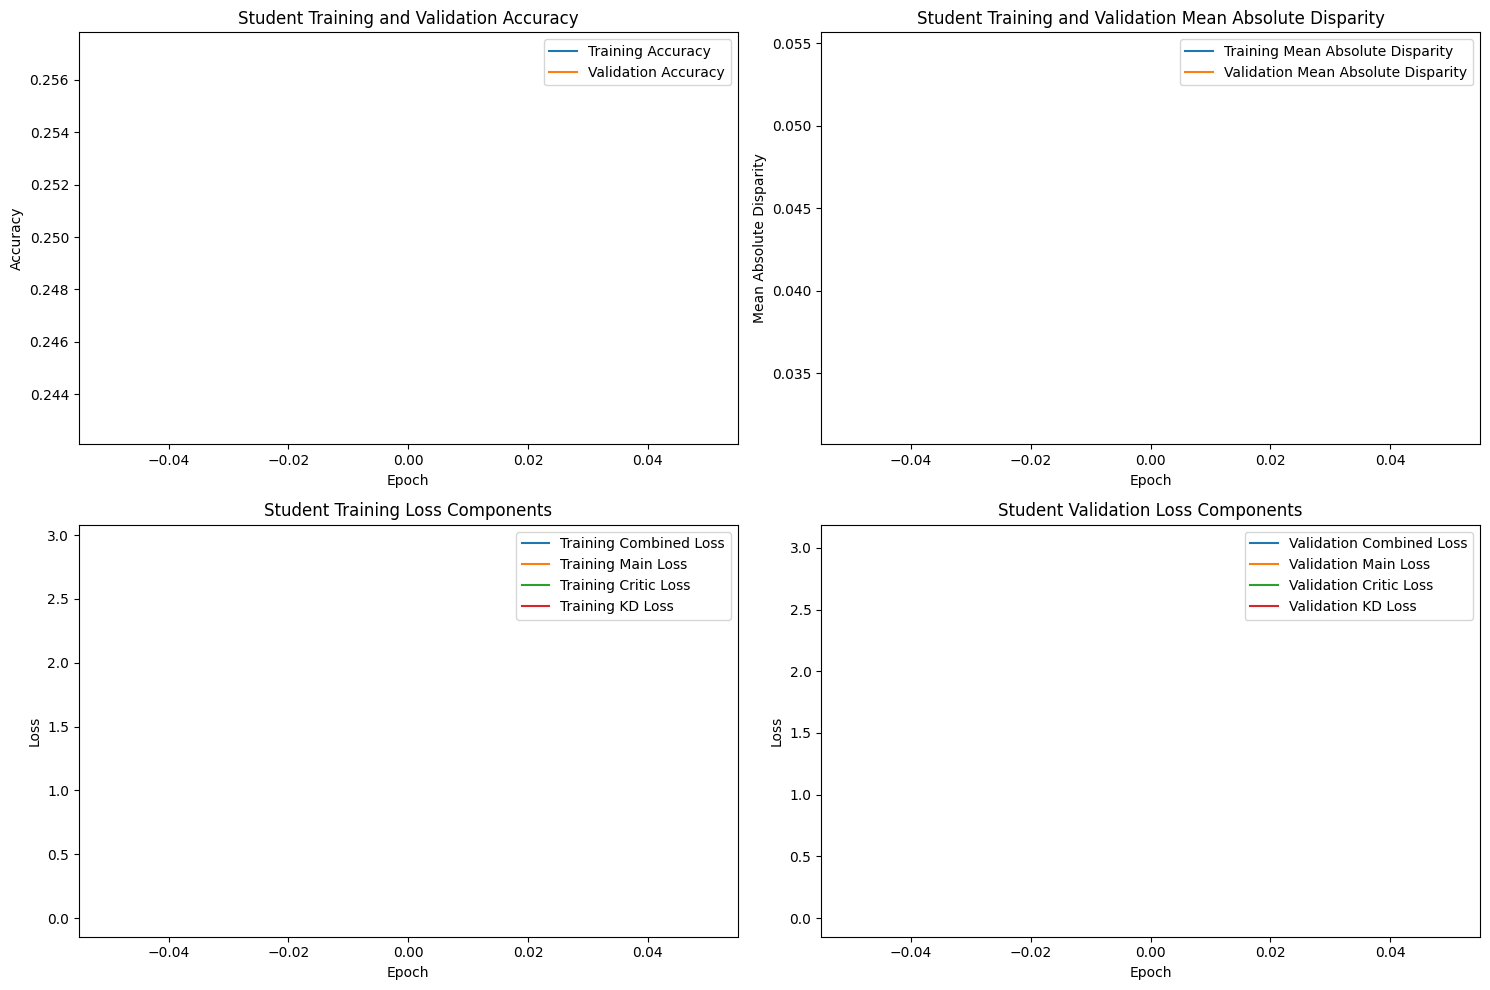

Epoch 2/200, Training:  78%|███████████████████▌     | 127/162 [01:30<00:24,  1.42it/s]

In [ ]:
# # STUDENT
# Create dict to store best model states
student_model_states_best = {}

# Specify the lambda_factor for the teacher model to load
lambda_factor = 0

# Define the path to the saved model file for this lambda_factor
lambda_dir = os.path.join(base_save_dir, f'TEACHER_lambda_{lambda_factor}')
teacher_path = os.path.join(lambda_dir, f'TEACHER_best_model_lambda_{lambda_factor}.pth')

# Initialize the EfficientNet model without pre-trained weights
teacher = models.efficientnet_b3(pretrained=False)

# Adjust the classifier layer to match your number of classes
num_ftrs = teacher.classifier[1].in_features
teacher.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Load the model state
teacher_best_model_state = torch.load(teacher_path)
teacher.load_state_dict(teacher_best_model_state['teacher_state_dict'])


# Loop through the lambda_factor_list
for lambda_factor in student_lambda_factor_list:
    # Load EfficientNet B0 model for Student
    student = models.efficientnet_b0(pretrained=True)
    
    # Determine the number of output features from the feature extractor part of EfficientNet B0
    num_ftrs = student.classifier[1].in_features  # This is the correct number of input features for your adversarial classifier
    
    # Modify the classifier layer of the EfficientNet model to match your number of classes
    student.classifier[1] = nn.Linear(num_ftrs, num_classes)
    

    # Initialize the Critic model
    critic = Critic(input_size=num_classes) # Adjust the input size based on your model's output
    critic_optimizer = optim.Adam(critic.parameters(), lr=student_learning_rate)
    critic_loss_fn = torch.nn.MSELoss()
    
    # Redefine your main model optimizer if needed
    student_optimizer = optim.Adam(student.parameters(), lr=student_learning_rate)
    student_loss_fn = nn.CrossEntropyLoss()

    # Train the model
    student_best_model_state = train_student(student, teacher, student_optimizer, student_loss_fn, critic, critic_optimizer, critic_loss_fn,
                                   lambda_factor, temperature, alpha, epsilon, margin, student_patience, student_epochs, device, base_save_dir=base_save_dir)
    student_model_states_best[lambda_factor] = student_best_model_state

# Save the collective best model states to a file
student_collective_save_path = os.path.join(base_save_dir, 'student_model_states_best.pth')
torch.save(student_model_states_best, student_collective_save_path)

In [ ]:
# # load models
# collective_save_path = os.path.join(base_save_dir, 'student_model_states_best.pth')

# # Load the saved model states
# teacher_model_states_best = torch.load(collective_save_path)

# # Example: Accessing the best_val_accuracy for a specific lambda value
# lambda_value = 50
# if lambda_value in teacher_model_states_best:
#     best_model_state = teacher_model_states_best[lambda_value]
#     best_val_accuracy = best_model_state['best_val_accuracy']
#     print(f"Best validation accuracy for lambda {lambda_value}: {best_val_accuracy}")
# else:
#     print(f"No model state found for lambda {lambda_value}")

### PLOTTING

In [ ]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    inputs = inputs.to(device)

    teacher_time, student_time = 0, 0

    if teacher is not None:
        teacher = teacher.to(device)
        start_time = time.time()
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
        teacher_time = time.time() - start_time

    if student is not None:
        student = student.to(device)
        start_time = time.time()
        with torch.no_grad():
            student_outputs = student(inputs)
        student_time = time.time() - start_time
    
    return teacher_time, student_time

In [ ]:
lambda_results = {}

# Loop through each lambda value
for lmda_teacher in teacher_lambda_factor_list:
    for lmda_student in student_lambda_factor_list:

        # Define the path to the saved model file for this lambda_factor
        lambda_dir = os.path.join(base_save_dir, f'TEACHER_lambda_{lmda_teacher}')
        teacher_path = os.path.join(lambda_dir, f'TEACHER_best_model_lambda_{lmda_teacher}.pth')
        
        # Initialize the EfficientNet model without pre-trained weights
        teacher_model = models.efficientnet_b3(pretrained=False)
        
        # Adjust the classifier layer to match your number of classes
        num_ftrs = teacher.classifier[1].in_features
        teacher_model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        
        # Load the model state
        teacher_best_model_state = torch.load(teacher_path)
        teacher_model.load_state_dict(teacher_best_model_state['teacher_state_dict'])
        teacher_model = teacher_model.to(device)
        
        # Define the path to the saved model file for this lambda_factor
        lambda_dir = os.path.join(base_save_dir, f'STUDENT_lambda_{lmda_student}')
        student_path = os.path.join(lambda_dir, f'STUDENT_best_model_lambda_{lmda_student}.pth')
        
        # Initialize the EfficientNet model without pre-trained weights
        student_model = models.efficientnet_b0(pretrained=False)
        
        # Adjust the classifier layer to match your number of classes
        num_ftrs = student_model.classifier[1].in_features
        student_model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        
        # Load the model state
        student_best_model_state = torch.load(student_path)
        student_model.load_state_dict(student_best_model_state['student_state_dict'])
        student_model = student_model.to(device)
        
        # Compute performance metrics
        performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    
        # Compute model sizes
        teacher_params, student_params = compare_model_size(teacher_model, student_model)
    
        # Construct a unique key for the current combination of lambda values
        lambda_key = (lmda_teacher, lmda_student)

        # Update results for the current lambda value
        if lambda_key in lambda_results:
            lambda_results[lambda_key].update({
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            })
        else:
            lambda_results[lambda_key] = {
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            }

In [ ]:
# Initialize lists to store accuracies
teacher_accuracies = []
student_accuracies = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Access the performance metrics for each pair
    teacher_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][0]
    student_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][1]

    # Append accuracies to the lists
    teacher_accuracies.append((lmda_teacher, teacher_accuracy))
    student_accuracies.append((lmda_student, student_accuracy))

# To plot, you might need to separate the lambda values and accuracies
teacher_lambdas, teacher_acc = zip(*teacher_accuracies)
student_lambdas, student_acc = zip(*student_accuracies)

# Plotting only with markers and no lines
plt.scatter(teacher_lambdas, teacher_acc, label='Teacher Accuracy', marker='o')
plt.scatter(student_lambdas, student_acc, label='Student Accuracy', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()

# Show plot
plt.show()

In [ ]:
# Initialize lists to store precisions
teacher_precisions = []
student_precisions = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the precision metrics for each pair
        teacher_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][0]
        student_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append precisions to the lists along with lambda values
    teacher_precisions.append((lmda_teacher, teacher_precision))
    student_precisions.append((lmda_student, student_precision))

# Extracting lambda values and precisions
teacher_lambdas, teacher_prec = zip(*teacher_precisions)
student_lambdas, student_prec = zip(*student_precisions)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_prec, label='Teacher Precision', marker='o')
plt.scatter(student_lambdas, student_prec, label='Student Precision', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store recalls
teacher_recalls = []
student_recalls = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the recall metrics for each pair
        teacher_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][0]
        student_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append recalls to the lists along with lambda values
    teacher_recalls.append((lmda_teacher, teacher_recall))
    student_recalls.append((lmda_student, student_recall))

# Extracting lambda values and recalls
teacher_lambdas, teacher_rec = zip(*teacher_recalls)
student_lambdas, student_rec = zip(*student_recalls)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_rec, label='Teacher Recall', marker='o')
plt.scatter(student_lambdas, student_rec, label='Student Recall', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store F1 scores
teacher_f1s = []
student_f1s = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the F1 scores for each pair
        teacher_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][0]
        student_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append F1 scores to the lists along with lambda values
    teacher_f1s.append((lmda_teacher, teacher_f1))
    student_f1s.append((lmda_student, student_f1))

# Extracting lambda values and F1 scores
teacher_lambdas, teacher_f1_scores = zip(*teacher_f1s)
student_lambdas, student_f1_scores = zip(*student_f1s)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_f1_scores, label='Teacher F1 Score', marker='o')
plt.scatter(student_lambdas, student_f1_scores, label='Student F1 Score', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
# Initialize lists to store model sizes
teacher_sizes = []
student_sizes = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the model sizes for each pair
        teacher_size = lambda_results[(lmda_teacher, lmda_student)]['teacher_params'] / 1e6  # Convert to millions
        student_size = lambda_results[(lmda_teacher, lmda_student)]['student_params'] / 1e6
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append model sizes to the lists along with lambda values
    teacher_sizes.append((lmda_teacher, teacher_size))
    student_sizes.append((lmda_student, student_size))

# Extracting lambda values and model sizes
teacher_lambdas, teacher_model_sizes = zip(*teacher_sizes)
student_lambdas, student_model_sizes = zip(*student_sizes)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_model_sizes, label='Teacher Model Size', marker='o')
plt.scatter(student_lambdas, student_model_sizes, label='Student Model Size', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
        # Define the path to the saved model file for this lambda_factor
        lambda_dir = os.path.join(base_save_dir, f'TEACHER_lambda_{lmda_teacher}')
        teacher_path = os.path.join(lambda_dir, f'TEACHER_best_model_lambda_{lmda_teacher}.pth')
        
        # Initialize the EfficientNet model without pre-trained weights
        teacher_model = models.efficientnet_b3(pretrained=False)
        
        # Adjust the classifier layer to match your number of classes
        num_ftrs = teacher.classifier[1].in_features
        teacher_model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        
        # Load the model state
        teacher_best_model_state = torch.load(teacher_path)
        teacher_model.load_state_dict(teacher_best_model_state['teacher_state_dict'])
        teacher_model = teacher_model.to(device)
        
        # Define the path to the saved model file for this lambda_factor
        lambda_dir = os.path.join(base_save_dir, f'STUDENT_lambda_{lmda_student}')
        student_path = os.path.join(lambda_dir, f'STUDENT_best_model_lambda_{lmda_student}.pth')
        
        # Initialize the EfficientNet model without pre-trained weights
        student_model = models.efficientnet_b0(pretrained=False)
        
        # Adjust the classifier layer to match your number of classes
        num_ftrs = student_model.classifier[1].in_features
        student_model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        
        # Load the model state
        student_best_model_state = torch.load(student_path)
        student_model.load_state_dict(student_best_model_state['student_state_dict'])
        student_model = student_model.to(device)

In [ ]:
# Initialize dictionaries to store inference times for each lambda value
teacher_times = {}
student_times = {}

# Loop through each lambda value
for lmda_teacher in teacher_lambda_factor_list:
    # Define the path to the saved model file for this lambda_factor
    lambda_dir = os.path.join(base_save_dir, f'TEACHER_lambda_{lmda_teacher}')
    teacher_path = os.path.join(lambda_dir, f'TEACHER_best_model_lambda_{lmda_teacher}.pth')
    
    # Initialize the EfficientNet model without pre-trained weights
    teacher_model = models.efficientnet_b3(pretrained=False)
    
    # Adjust the classifier layer to match your number of classes
    num_ftrs = teacher.classifier[1].in_features
    teacher_model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    # Load the model state
    teacher_best_model_state = torch.load(teacher_path)
    teacher_model.load_state_dict(teacher_best_model_state['teacher_state_dict'])
    teacher_model = teacher_model.to(device)

    teacher_time, _ = compare_inference_time(teacher_model, None, testloader)
    teacher_times[lmda_teacher] = teacher_time  # Store the inference time for the teacher model

for lmda_student in student_lambda_factor_list:
    # Define the path to the saved model file for this lambda_factor
    lambda_dir = os.path.join(base_save_dir, f'STUDENT_lambda_{lmda_student}')
    student_path = os.path.join(lambda_dir, f'STUDENT_best_model_lambda_{lmda_student}.pth')
    
    # Initialize the EfficientNet model without pre-trained weights
    student_model = models.efficientnet_b0(pretrained=False)
    
    # Adjust the classifier layer to match your number of classes
    num_ftrs = student_model.classifier[1].in_features
    student_model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    # Load the model state
    student_best_model_state = torch.load(student_path)
    student_model.load_state_dict(student_best_model_state['student_state_dict'])
    student_model = student_model.to(device)

    _, student_time = compare_inference_time(None, student_model, testloader)
    student_times[lmda_student] = student_time  # Store the inference time for the student model

# Extracting lambda values and inference times
teacher_lambdas, teacher_inference_times = zip(*teacher_times.items())
student_lambdas, student_inference_times = zip(*student_times.items())

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_inference_times, label='Teacher Inference Time', marker='o')
plt.scatter(student_lambdas, student_inference_times, label='Student Inference Time', marker='o')

# Adding labels and title
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
teacher_disparities = []
student_disparities = []

# Loop through each lambda_factor in the teacher_lambda_factor_list and extract the disparity values for the teacher
for lambda_factor in teacher_lambda_factor_list:
    # Load teacher model
    teacher_path = os.path.join(base_save_dir, f'TEACHER_lambda_{lambda_factor}', f'TEACHER_best_model_lambda_{lambda_factor}.pth')
    teacher_best_model_state = torch.load(teacher_path)
    teacher_disparities.append((lambda_factor, teacher_best_model_state['best_val_mean_abs_disparity']))

# Loop through each lambda_factor in the student_lambda_factor_list and extract the disparity values for the student
for lambda_factor in student_lambda_factor_list:
    # Load student model
    student_path = os.path.join(base_save_dir, f'STUDENT_lambda_{lambda_factor}', f'STUDENT_best_model_lambda_{lambda_factor}.pth')
    student_best_model_state = torch.load(student_path)
    student_disparities.append((lambda_factor, student_best_model_state['best_val_mean_abs_disparity']))

# Unpack the lambda factors and disparities for plotting
teacher_lambdas, teacher_disp_values = zip(*teacher_disparities)
student_lambdas, student_disp_values = zip(*student_disparities)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(teacher_lambdas, teacher_disp_values, label='Teacher', color='blue')
plt.scatter(student_lambdas, student_disp_values, label='Student', color='red')
plt.xlabel('Lambda Factor')
plt.ylabel('Best Val Mean Abs Disparity')
plt.title('Best Validation Mean Absolute Disparity vs Lambda Factor')
plt.legend()
plt.show()


In [ ]:
def plot_distribution(predictions, class_names, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=predictions)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, predictions, class_names, title):
    cm = confusion_matrix(all_labels, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to generate predictions and compute metrics
def generate_predictions_and_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return all_labels, all_preds

# Loop over each lambda value for the teacher model
for lmda_teacher in teacher_lambda_factor_list:
    # Define the path to the saved model file for this lambda_factor
    lambda_dir = os.path.join(base_save_dir, f'TEACHER_lambda_{lmda_teacher}')
    teacher_path = os.path.join(lambda_dir, f'TEACHER_best_model_lambda_{lmda_teacher}.pth')
    
    # Initialize the EfficientNet model without pre-trained weights
    teacher_model = models.efficientnet_b3(pretrained=False)
    
    # Adjust the classifier layer to match your number of classes
    num_ftrs = teacher.classifier[1].in_features
    teacher_model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    # Load the model state
    teacher_best_model_state = torch.load(teacher_path)
    teacher_model.load_state_dict(teacher_best_model_state['teacher_state_dict'])
    teacher_model = teacher_model.to(device)
    
    # Generate predictions for the teacher model
    all_labels, all_teacher_preds = generate_predictions_and_metrics(teacher_model, testloader)

    # Plot distribution and confusion matrix for the teacher model
    plot_distribution(all_teacher_preds, class_names_new, f'Teacher Model Predictions (Lambda={lmda_teacher})')
    plot_confusion_matrix(all_labels, all_teacher_preds, class_names_new, f'Teacher Confusion Matrix (Lambda={lmda_teacher})')

    # Print classification report for the teacher model
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda_teacher})')
    print(teacher_report)

# Loop over each lambda value for the student model
for lmda_student in student_lambda_factor_list:
    # Define the path to the saved model file for this lambda_factor
    lambda_dir = os.path.join(base_save_dir, f'STUDENT_lambda_{lmda_student}')
    student_path = os.path.join(lambda_dir, f'STUDENT_best_model_lambda_{lmda_student}.pth')
    
    # Initialize the EfficientNet model without pre-trained weights
    student_model = models.efficientnet_b0(pretrained=False)
    
    # Adjust the classifier layer to match your number of classes
    num_ftrs = student_model.classifier[1].in_features
    student_model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    # Load the model state
    student_best_model_state = torch.load(student_path)
    student_model.load_state_dict(student_best_model_state['student_state_dict'])
    student_model = student_model.to(device)

    # Generate predictions for the student model
    all_labels, all_student_preds = generate_predictions_and_metrics(student_model, testloader)

    # Plot distribution and confusion matrix for the student model
    plot_distribution(all_student_preds, class_names_new, f'Student Model Predictions (Lambda={lmda_student})')
    plot_confusion_matrix(all_labels, all_student_preds, class_names_new, f'Student Confusion Matrix (Lambda={lmda_student})')

    # Print classification report for the student model
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Student Model (Lambda={lmda_student})')
    print(student_report)

In [ ]:
def plot_bias_variance_tradeoff(base_save_dir, model_type, lambda_list):
    bias_values = []
    accuracy_values = []

    for lambda_factor in lambda_list:
        model_path = os.path.join(base_save_dir, f'{model_type.upper()}_lambda_{lambda_factor}', f'{model_type.upper()}_best_model_lambda_{lambda_factor}.pth')
        if os.path.exists(model_path):
            model_state = torch.load(model_path)

            disparity = model_state['best_val_mean_abs_disparity']
            accuracy = model_state['best_val_accuracy']
            bias_values.append(disparity)
            accuracy_values.append(accuracy)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(bias_values, accuracy_values, label=f'{model_type.title()} Model')
    plt.xlabel('Mean Absolute Disparity')
    plt.ylabel('Validation Accuracy')
    plt.title(f'{model_type.title()} Model Accuracy vs Disparity')
    for i, lambda_factor in enumerate(lambda_list):
        plt.annotate(f'λ={lambda_factor}', (bias_values[i], accuracy_values[i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.legend()
    plt.show()

# Plot for Teacher
plot_bias_variance_tradeoff(base_save_dir, 'teacher', teacher_lambda_factor_list)

# Plot for Student
plot_bias_variance_tradeoff(base_save_dir, 'student', student_lambda_factor_list)

In [ ]:
def compare_performance_metrics_for_demo(teacher, student, dataloader):
    teacher.eval()
    student.eval()

    detailed_info = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        # Assuming gender or other attributes are part of 'target'
        attributes = batch['target'].to(device)  

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

        teacher_preds = torch.argmax(teacher_outputs, dim=1)
        student_preds = torch.argmax(student_outputs, dim=1)

        for i in range(inputs.size(0)):
            if teacher_preds[i] != labels[i] and student_preds[i] == labels[i]:
                info = {
                    'image': inputs[i],
                    'actual_class': labels[i].item(),
                    'teacher_pred_class': teacher_preds[i].item(),
                    'student_pred_class': student_preds[i].item(),
                    'actual_attribute': attributes[i].item(),  # Modify based on your dataset
                    # If your model also predicts attributes, include them here
                }
                detailed_info.append(info)

    return detailed_info

In [ ]:
def plot_images_with_class_filter(info_list, display_class, new_label_mapping, rows=10, cols=5):
    # Filter the info list based on the specified class, student correct and teacher incorrect predictions
    filtered_info = [info for info in info_list if info['actual_class'] == display_class and 
                     info['student_pred_class'] == display_class and 
                     info['teacher_pred_class'] != display_class]

    # Calculate the number of images to display based on the length of the filtered list
    num_images = len(filtered_info)
    if num_images == 0:
        print(f"No images to display for class {display_class}.")
        return  # Skip this class as there are no images to display

    total_plots = min(rows * cols, num_images)  # Ensure we don't exceed the number of filtered images

    # Determine the number of rows needed based on the number of images
    rows = (total_plots + cols - 1) // cols

    # Create a figure with the adjusted number of rows and columns
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.ravel()

    for i in range(total_plots):
        data = filtered_info[i]
        image = data['image']
        actual_class = new_label_mapping[data['actual_class']]  # Get class name from the mapping
        teacher_pred_class = new_label_mapping[data['teacher_pred_class']]  # Get class name from the mapping
        student_pred_class = new_label_mapping[data['student_pred_class']]  # Get class name from the mapping
        actual_attribute = round(data['actual_attribute'], 3)
    
        # Normalize the image for display
        image_display = image.cpu().numpy().transpose(1, 2, 0)
        image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())
    
        # Set the title with the class and attribute information
        title = f'Attr: {actual_attribute}\nTrue: {actual_class}\nTeacher: {teacher_pred_class}\nStudent: {student_pred_class}'
    
        axes[i].imshow(image_display)
        axes[i].set_title(title, fontsize=12, pad=4)
        axes[i].axis('off')

    # Turn off any unused axes
    for i in range(total_plots, len(axes)):
        axes[i].axis('off')

    # Adjust layout for clarity
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.show()


In [ ]:
# Load the Teacher Model for a specific lambda value
def load_teacher_model(lambda_factor):
    lambda_dir = os.path.join(base_save_dir, f'TEACHER_lambda_{lambda_factor}')
    teacher_path = os.path.join(lambda_dir, f'TEACHER_best_model_lambda_{lambda_factor}.pth')

    teacher_model = models.efficientnet_b3(pretrained=False)
    num_ftrs = teacher_model.classifier[1].in_features
    teacher_model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)

    teacher_best_model_state = torch.load(teacher_path)
    teacher_model.load_state_dict(teacher_best_model_state['teacher_state_dict'])
    teacher_model = teacher_model.to(device)
    return teacher_model

# Load the Student Model for a specific lambda value
def load_student_model(lambda_factor):
    lambda_dir = os.path.join(base_save_dir, f'STUDENT_lambda_{lambda_factor}')
    student_path = os.path.join(lambda_dir, f'STUDENT_best_model_lambda_{lambda_factor}.pth')

    student_model = models.efficientnet_b0(pretrained=False)
    num_ftrs = student_model.classifier[1].in_features
    student_model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)

    student_best_model_state = torch.load(student_path)
    student_model.load_state_dict(student_best_model_state['student_state_dict'])
    student_model = student_model.to(device)
    return student_model

# Load models for a specific lambda value
teacher_lambda_factor = 0 
student_lambda_factor = 50

teacher_model = load_teacher_model(teacher_lambda_factor)
student_model = load_student_model(student_lambda_factor)

# Assuming 'testloader', 'new_label_mapping', and 'num_classes' are defined
# Get detailed info where student is correct and teacher is wrong
detailed_info = compare_performance_metrics_for_demo(teacher_model, student_model, testloader)

# Plot images
for i in range(num_classes):
    print('='*60)
    print(f'CLASS {i}: {new_label_mapping[i]}')
    print('='*60)
    plot_images_with_class_filter(detailed_info, display_class=i, new_label_mapping=new_label_mapping, rows=100, cols=5)
